In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

定义损失函数，是新的聚类中心和旧的聚类中心的欧拉距离和，用来作为判断程序是否需要停止迭代的条件

In [32]:
def distance_diff(cur_centroids: list, prev_centroids: list) -> np.ndarray:
    """
    计算当前聚类中心和上一次聚类中心的欧拉距离之和（即像素点坐标差的平方和）

    :param cur_centroids: 当前的聚类中心
    :param prev_centroids: 上一次的聚类中心
    :return:
    """
    cur_centroids = np.array(cur_centroids)
    prev_centroids = np.array(prev_centroids)

    return np.sum((cur_centroids - prev_centroids) ** 2)

分类器，用来将每一个样本点打上对应的类别标签。通过计算与聚类中心的距离找到最小距离的聚类中心，打上标签。

In [33]:
def classifier(data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    分类器，通过像素点 matrix 和聚类中心给所有像素点分类（即打上标签）

    :param data: 输入数据（在这里指图像的像素 matrix）
    :param centroids: 聚类中心
    :return: 标签矩阵，size 和 data 的 size 相同
    """
    row_count, col_count = data.shape
    # 用来存储所有像素的标签
    pixels_labels = np.zeros((row_count, col_count))
    pixel_distance = []

    for i in range(row_count):
        for j in range(col_count):
            # 计算像素点与每个 centroid 的欧拉距离
            for k in range(len(centroids)):
                distance = np.sum(abs((data[i, j]).astype(int) - centroids[k].astype(int)) ** 2)
                pixel_distance.append(distance)
            # 找到距离最小的 centroid，该像素点就是该类
            pixels_labels[i, j] = int(pixel_distance.index(min(pixel_distance)))
            pixel_distance = []

    return pixels_labels

In [36]:
def kmeans(data: np.ndarray, cluster_num: int, max_iter: int, min_loss: float = 1) -> np.ndarray:
    """

    :param data: 输入数据，即图像的像素点矩阵
    :param cluster_num: 类别数量
    :param max_iter: 最大的迭代次数，作为判断是否停止迭代的一个条件
    :param min_loss: 最小的损失函数的值，作为判断是否停止迭代的一个条件
    :return: 分类后的图像标签矩阵
    """
    data_copy = np.copy(data)
    print("data shape: " + str(data_copy.shape))
    input_row, input_col = data_copy.shape
    pixels_labels = np.zeros((input_row, input_col))

    # 随机初始聚类中心
    initial_centroid_row_num = [i for i in range(input_row)]
    random.shuffle(initial_centroid_row_num)
    initial_centroid_row_num = initial_centroid_row_num[:cluster_num]

    initial_centroid_col_num = [i for i in range(input_col)]
    random.shuffle(initial_centroid_col_num)
    initial_centroid_col_num = initial_centroid_col_num[:cluster_num]

    # 当前的聚类中心
    cur_centroids = []
    for i in range(cluster_num):
        cur_centroids.append(data_copy[initial_centroid_row_num[i], initial_centroid_col_num[i]])

    pixels_labels = classifier(data_copy, cur_centroids)

    iter_count = 0  # 用于记录迭代次数
    while True:
        prev_centroids = cur_centroids.copy()  # 储存前一次的聚类中心
        # 计算当前聚类中心
        for n in range(cluster_num):
            temp = np.where(pixels_labels == n)
            cur_centroids[n] = sum(data_copy[temp].astype(int)) / len(data_copy[temp])

        # 根据当前聚类中心分类
        pixels_labels = classifier(data_copy, cur_centroids)
        # 计算上一次聚类中心与当前聚类中心的差异
        loss = distance_diff(cur_centroids, prev_centroids)
        iter_count += 1
        print("Step:" + str(iter_count) + "  Loss:" + str(loss))
        # 当损失小于迭代阈值时，结束迭代
        if iter_count >= max_iter or loss < min_loss:
            break

    return pixels_labels

gray img: [[157 151 153 ...  90  84  88]
 [152 150 150 ...  87  81  86]
 [143 145 139 ...  83  79  85]
 ...
 [ 63  54  55 ...  73  77  81]
 [ 63  52  53 ...  77  81  84]
 [ 63  51  51 ...  81  85  87]]
data shape: (2160, 3840)
Step:1  Loss:1800.5883401963652
Step:2  Loss:227.60429477912882
Step:3  Loss:71.6506476672127
Step:4  Loss:34.74313722512677
Step:5  Loss:27.219128226623365
Step:6  Loss:13.032921079550697
Step:7  Loss:5.359871945358659
Step:8  Loss:3.2860924338914455
Step:9  Loss:1.4298680126699197
Step:10  Loss:1.5464917448268127
Step:11  Loss:0.5554864919099217
data shape: (2160, 3840)
Step:1  Loss:1571.9980051718117
Step:2  Loss:50.36579257599441
Step:3  Loss:5.479468487453547
Step:4  Loss:0.8119038764361843
Step:5  Loss:0.0
data shape: (2160, 3840)
Step:1  Loss:1551.9496061296322
Step:2  Loss:143.22748873906784
Step:3  Loss:28.636082776139048
Step:4  Loss:10.545298499984805
Step:5  Loss:5.475532585944573
Step:6  Loss:4.576942122760083
Step:7  Loss:3.2906561363425744
Step:8  

<Figure size 640x480 with 0 Axes>

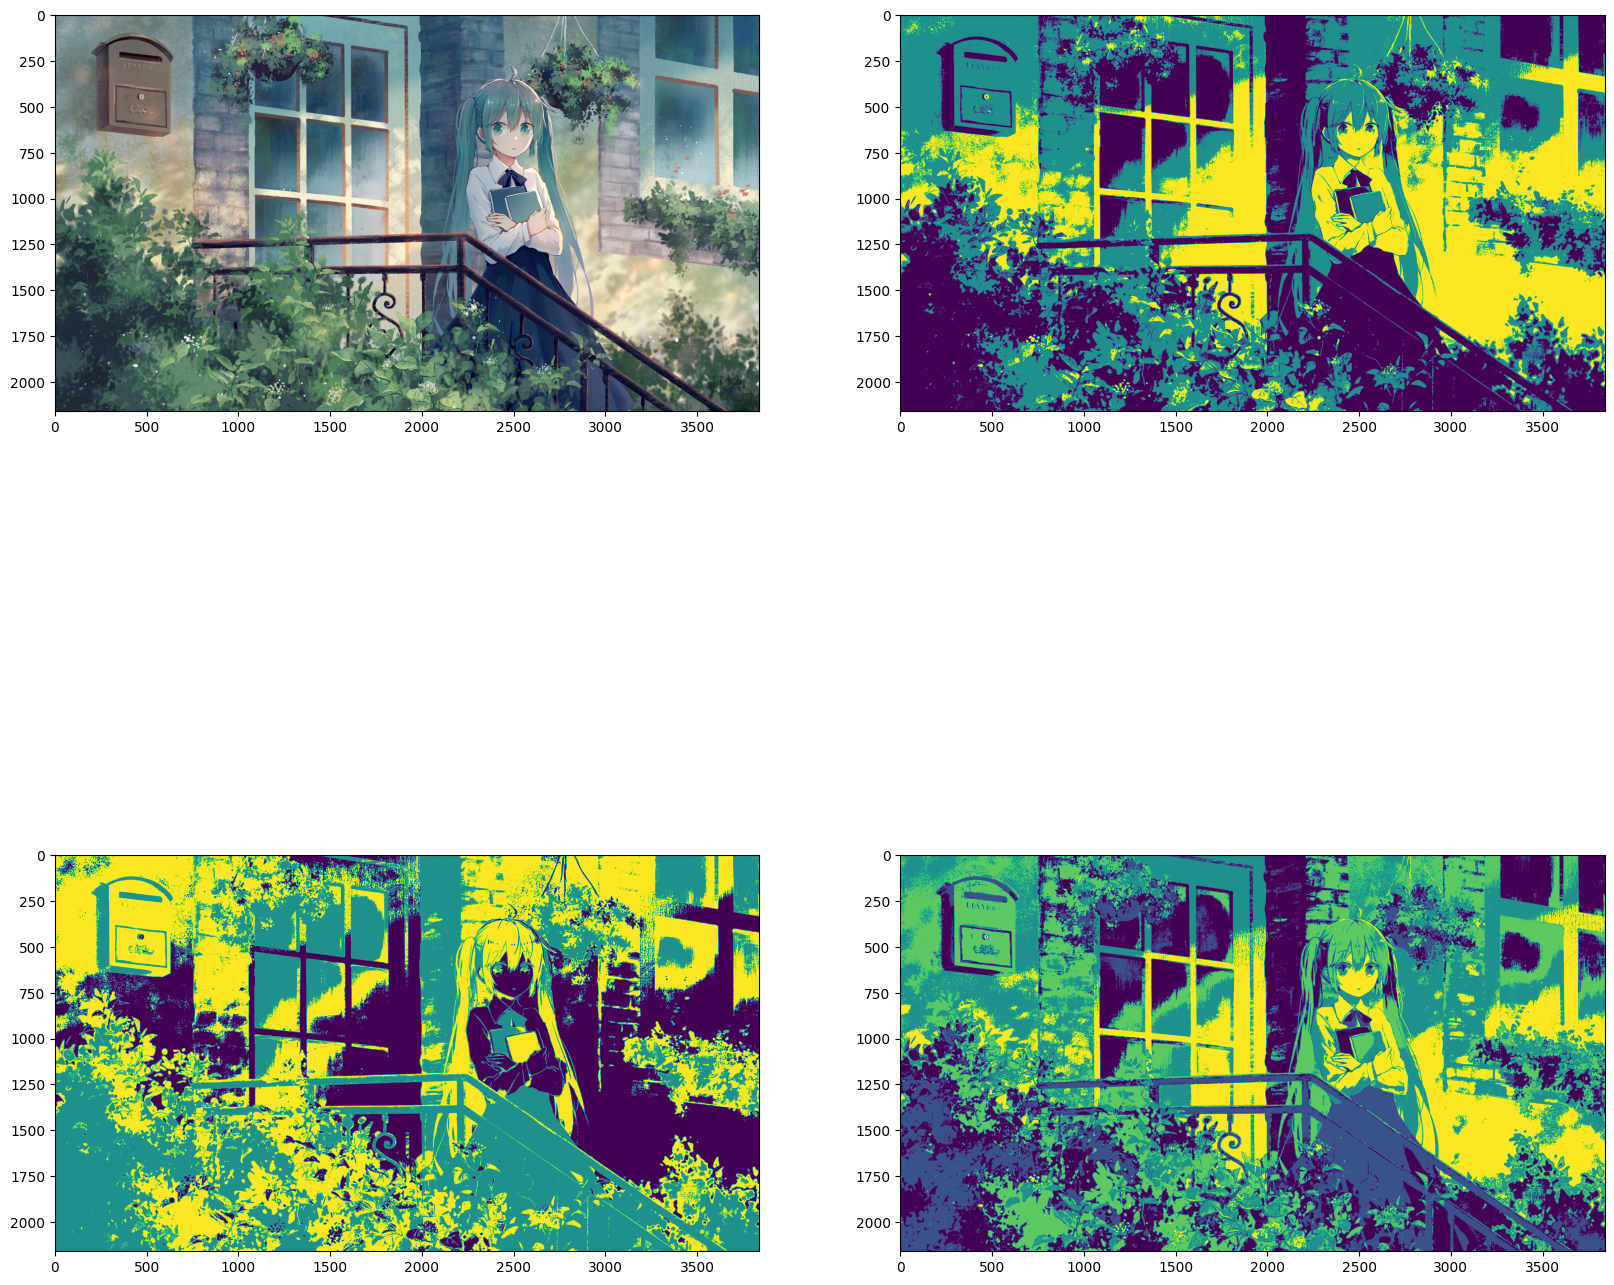

In [40]:
# 这里通过 opencv 读取的图片并不是 rgb 通道，而是 bgr 的
img = cv2.imread("../img/kmeans-image.jpg")
b, g, r = cv2.split(img)
img_rgb = cv2.merge((r, g, b))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("gray img: " + str(img_gray))

plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0][0].imshow(img_rgb)

axes[0][1].imshow(kmeans(img_gray, cluster_num=3, max_iter=20))
axes[1][0].imshow(kmeans(img_gray, cluster_num=3, max_iter=20, min_loss=0.5))
axes[1][1].imshow(kmeans(img_gray, cluster_num=5, max_iter=20))
plt.show()